# EXPERIMENT 16: Spectral Forensics on Momentum Attention (Ref: Appendix-P)
## "The Bode Plot of Emergence"

**Project:** Momentum Attention: A Hamiltonian Prior for In-Context Learning and spectral Forensics for Mechanistic Interpetability


---

### This notebook:
1. **Reproduces EXPT 15d results** (exact architecture, dataset, hyperparameters)
2. **Adds spectral forensics** - analyzes attention patterns in frequency domain
3. **Generates "The Bode Plot of AI"** - the signature visualization

### Theoretical Foundation

Momentum augmentation $p_t = q_t - q_{t-1}$ corresponds to the transfer function:

$$H_{mom}(\omega) = 1 + \gamma(1 - e^{-j\omega})$$

This is a **HIGH-PASS FILTER** that amplifies temporal derivatives.

In [ ]:
# =============================================================================
# PART 0: IMPORTS AND SETUP
# =============================================================================

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Optional, Dict, List, Tuple
import json
import os
from datetime import datetime
import math

try:
    from tqdm.notebook import tqdm
except ImportError:
    from tqdm import tqdm

# Reproducibility
torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

# Output directory
OUTPUT_DIR = './expt16_corrected_results'
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"Output: {OUTPUT_DIR}")

Device: cuda
GPU: NVIDIA A100-SXM4-40GB
Memory: 42.5 GB
Output: ./expt16_corrected_results


In [ ]:
# =============================================================================
# PART 1: CONFIGURATION (IDENTICAL TO EXPT 15d)
# =============================================================================

@dataclass
class ExperimentConfig:
    """Configuration for EXPT 16 - IDENTICAL to EXPT 15d"""

    # Model Architecture
    vocab_size: int = 1000  # Token 999 reserved as ANCHOR
    d_model: int = 256
    n_layers: int = 4
    n_heads: int = 8
    d_head: int = 32
    d_ff: int = 1024
    max_seq_len: int = 512
    dropout: float = 0.1
    rope_base: float = 10000.0

    # Momentum Configuration
    gamma: float = 0.2
    beta: float = 0.0

    # Anchored ICL Dataset Configuration - STRESS TEST
    seq_length: int = 512
    chain_length: int = 30  # L=30 STRESS TEST
    num_chains: int = 4
    chain_insert_prob: float = 0.4
    query_insert_prob: float = 0.4

    # Training Configuration
    batch_size: int = 32
    n_train_steps: int = 10000
    learning_rate: float = 3e-4
    weight_decay: float = 0.01
    warmup_steps: int = 500
    eval_every: int = 500

    # Spectral Analysis
    n_spectral_samples: int = 500

config = ExperimentConfig()

print("="*60)
print("EXPERIMENT 16: SPECTRAL FORENSICS (CORRECTED)")
print("="*60)
print(f"\nModel: d={config.d_model}, L={config.n_layers}, H={config.n_heads}")
print(f"Momentum: γ={config.gamma}")
print(f"\n🔥 CHAIN LENGTH: {config.chain_length} (STRESS TEST)")
print(f"\nTheoretical Prediction:")
print(f"  Baseline: 0.95^{config.chain_length} ≈ {0.95**config.chain_length:.1%} signal (CRASH)")
print(f"  Momentum: Linear decay (guide rail effect)")
print(f"\nANCHOR Token ID: {config.vocab_size - 1}")
print(f"Training: {config.n_train_steps} steps, batch={config.batch_size}")

EXPERIMENT 16: SPECTRAL FORENSICS (CORRECTED)

Model: d=256, L=4, H=8
Momentum: γ=0.2

🔥 CHAIN LENGTH: 30 (STRESS TEST)

Theoretical Prediction:
  Baseline: 0.95^30 ≈ 21.5% signal (CRASH)
  Momentum: Linear decay (guide rail effect)

ANCHOR Token ID: 999
Training: 10000 steps, batch=32


In [ ]:
# =============================================================================
# PART 2: ANCHORED ICL DATASET (IDENTICAL TO EXPT 15d)
# =============================================================================

class AnchoredICLDataset(Dataset):
    """
    Generates Anchored Chains to enforce Kinematic Consistency.

    Structure: [ANCHOR] → A → B → C → ... (up to 30 tokens!)

    The ANCHOR token ensures that the momentum vector p_A is identical
    whether A appears in a lesson or a query.

    STRESS TEST: With L=30, we expect:
    - Baseline to CRASH (exponential decay: 0.95^30 ≈ 21%)
    - Momentum to survive (linear decay via guide rail)
    """

    def __init__(self, config: ExperimentConfig, n_samples: int = 10000):
        self.config = config
        self.n_samples = n_samples
        self.chain_length = config.chain_length
        self.num_chains = config.num_chains

        # Reserve the LAST token ID as the special Anchor
        self.anchor_token = config.vocab_size - 1

        # Pre-generate all sequences
        print(f"Generating {n_samples} sequences...")
        self.sequences = self._generate_all_sequences()

    def _generate_all_sequences(self) -> torch.Tensor:
        sequences = []
        for _ in tqdm(range(self.n_samples), desc="Dataset"):
            seq = self._generate_single_sequence()
            sequences.append(seq)
        return torch.stack(sequences)

    def _generate_single_sequence(self) -> torch.Tensor:
        """Generate a sequence with ANCHORED chains of length 30."""
        cfg = self.config
        final_seq = []

        # 1. Create a pool of chains (sample from vocab EXCLUDING anchor)
        chains = []
        for _ in range(self.num_chains):
            chain = np.random.choice(
                cfg.vocab_size - 1,  # Exclude anchor
                size=self.chain_length,
                replace=False
            )
            chains.append(chain)

        # 2. Build the sequence
        target_len = cfg.seq_length

        while len(final_seq) < target_len:
            r = np.random.random()

            if r < cfg.chain_insert_prob:
                # INSERT ANCHORED DEFINITION (The "Lesson")
                which_chain = chains[np.random.randint(0, self.num_chains)]
                final_seq.append(self.anchor_token)
                final_seq.extend(which_chain.tolist())

            elif r < cfg.chain_insert_prob + cfg.query_insert_prob:
                # INSERT ANCHORED QUERY (The "Test")
                which_chain = chains[np.random.randint(0, self.num_chains)]
                start = np.random.randint(0, self.chain_length - 1)
                max_chunk = min(8, self.chain_length - start)
                chunk_len = np.random.randint(2, max_chunk + 1)
                chunk = which_chain[start:start + chunk_len]
                final_seq.append(self.anchor_token)
                final_seq.extend(chunk.tolist())

            else:
                # INSERT NOISE (No anchor)
                noise_len = np.random.randint(5, 20)
                noise = np.random.randint(0, cfg.vocab_size - 1, size=noise_len)
                final_seq.extend(noise.tolist())

        return torch.tensor(final_seq[:target_len], dtype=torch.long)

    def __len__(self) -> int:
        return self.n_samples

    def __getitem__(self, idx: int) -> torch.Tensor:
        return self.sequences[idx]


# Test the dataset
print("\nTesting Anchored ICL Dataset (L=30)...")
test_dataset = AnchoredICLDataset(config, n_samples=100)
sample = test_dataset[0]
print(f"Sample shape: {sample.shape}")
print(f"Chain length: {config.chain_length}")
anchor_count = (sample == config.vocab_size - 1).sum().item()
print(f"Anchor occurrences in sample: {anchor_count}")


Testing Anchored ICL Dataset (L=30)...
Generating 100 sequences...


Dataset:   0%|          | 0/100 [00:00<?, ?it/s]

Sample shape: torch.Size([512])
Chain length: 30
Anchor occurrences in sample: 28


In [ ]:
# =============================================================================
# PART 3: ROTARY POSITION EMBEDDING (IDENTICAL TO EXPT 15d)
# =============================================================================

class RotaryPositionEmbedding(nn.Module):
    """Rotary Position Embedding (RoPE)."""

    def __init__(self, d_head: int, max_seq_len: int = 2048, base: float = 10000.0):
        super().__init__()
        self.d_head = d_head

        inv_freq = 1.0 / (base ** (torch.arange(0, d_head, 2).float() / d_head))
        self.register_buffer('inv_freq', inv_freq)

        t = torch.arange(max_seq_len).float()
        freqs = torch.einsum('i,j->ij', t, inv_freq)
        emb = torch.cat([freqs, freqs], dim=-1)
        self.register_buffer('cos_cached', emb.cos())
        self.register_buffer('sin_cached', emb.sin())

    def _rotate_half(self, x: torch.Tensor) -> torch.Tensor:
        x1 = x[..., :x.shape[-1] // 2]
        x2 = x[..., x.shape[-1] // 2:]
        return torch.cat([-x2, x1], dim=-1)

    def forward(self, x: torch.Tensor, seq_len: int = None) -> torch.Tensor:
        if seq_len is None:
            seq_len = x.shape[2]
        cos = self.cos_cached[:seq_len].unsqueeze(0).unsqueeze(0)
        sin = self.sin_cached[:seq_len].unsqueeze(0).unsqueeze(0)
        return (x * cos) + (self._rotate_half(x) * sin)


print("RoPE module defined ✓")

RoPE module defined ✓


In [ ]:
# =============================================================================
# PART 4: MOMENTUM-AUGMENTED ATTENTION (IDENTICAL TO EXPT 15d)
# =============================================================================
#
# CRITICAL: Momentum is applied to Q and K AFTER RoPE, in HEAD space.
# This is the key difference from the broken EXPT 16 which applied momentum
# at the embedding level.
#
# =============================================================================

class MomentumMultiHeadAttention(nn.Module):
    """
    Momentum-Augmented Multi-Head Attention.

    CRITICAL: Momentum is computed and applied AFTER projections and RoPE.
    This ensures the derivative operator acts in the correct space.

    Transfer function: H_mom(ω) = 1 + γ(1 - e^{-jω})
    """

    def __init__(
        self,
        d_model: int,
        n_heads: int,
        d_head: int,
        dropout: float = 0.1,
        max_seq_len: int = 2048,
        rope_base: float = 10000.0,
        gamma: float = 0.0,
        beta: float = 0.0,
    ):
        super().__init__()

        self.d_model = d_model
        self.n_heads = n_heads
        self.d_head = d_head
        self.gamma = gamma
        self.beta = beta
        self.scale = 1.0 / math.sqrt(d_head)

        self.W_q = nn.Linear(d_model, n_heads * d_head, bias=False)
        self.W_k = nn.Linear(d_model, n_heads * d_head, bias=False)
        self.W_v = nn.Linear(d_model, n_heads * d_head, bias=False)
        self.W_o = nn.Linear(n_heads * d_head, d_model, bias=False)

        self.rope = RotaryPositionEmbedding(d_head, max_seq_len, rope_base)
        self.dropout = nn.Dropout(dropout)

        # Store attention weights for spectral analysis
        self.last_attn_weights = None

    def _compute_momentum(self, x: torch.Tensor) -> torch.Tensor:
        """Kinematic momentum: p_t = q_t - q_{t-1}

        This is the discrete derivative, which acts as a high-pass filter.
        """
        momentum = torch.zeros_like(x)
        momentum[:, :, 1:, :] = x[:, :, 1:, :] - x[:, :, :-1, :]
        return momentum

    def forward(
        self,
        x: torch.Tensor,
        attention_mask: Optional[torch.Tensor] = None,
        return_attention: bool = False,
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        batch_size, seq_len, _ = x.shape

        # Project to Q, K, V
        q = self.W_q(x).view(batch_size, seq_len, self.n_heads, self.d_head)
        k = self.W_k(x).view(batch_size, seq_len, self.n_heads, self.d_head)
        v = self.W_v(x).view(batch_size, seq_len, self.n_heads, self.d_head)

        # Transpose to [B, H, T, D]
        q = q.transpose(1, 2)
        k = k.transpose(1, 2)
        v = v.transpose(1, 2)

        # Apply RoPE FIRST
        q_pos = self.rope(q, seq_len)
        k_pos = self.rope(k, seq_len)

        # THEN apply momentum augmentation (CRITICAL!)
        if self.gamma > 0:
            p_q = self._compute_momentum(q_pos)
            p_k = self._compute_momentum(k_pos)
            q_aug = q_pos + self.gamma * p_q
            k_aug = k_pos + self.gamma * p_k
        else:
            q_aug = q_pos
            k_aug = k_pos

        # Scaled dot-product attention
        attn_scores = torch.matmul(q_aug, k_aug.transpose(-2, -1)) * self.scale

        # Causal mask
        if attention_mask is None:
            causal_mask = torch.triu(
                torch.ones(seq_len, seq_len, device=x.device, dtype=torch.bool),
                diagonal=1
            )
            attn_scores = attn_scores.masked_fill(causal_mask, float('-inf'))
        else:
            attn_scores = attn_scores.masked_fill(attention_mask, float('-inf'))

        attn_weights = F.softmax(attn_scores, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Store for spectral analysis
        self.last_attn_weights = attn_weights.detach()

        # Apply attention to values
        output = torch.matmul(attn_weights, v)
        output = output.transpose(1, 2).contiguous().view(batch_size, seq_len, -1)
        output = self.W_o(output)

        return output, attn_weights


print("MomentumMultiHeadAttention defined ✓")
print("  - Momentum applied to Q,K AFTER RoPE (CORRECT)")
print("  - Transfer function: H(ω) = 1 + γ(1 - e^{-jω})")

MomentumMultiHeadAttention defined ✓
  - Momentum applied to Q,K AFTER RoPE (CORRECT)
  - Transfer function: H(ω) = 1 + γ(1 - e^{-jω})


In [ ]:
# =============================================================================
# PART 5: TRANSFORMER MODEL (IDENTICAL TO EXPT 15d)
# =============================================================================

class RMSNorm(nn.Module):
    """Root Mean Square Layer Normalization."""
    def __init__(self, d_model: int, eps: float = 1e-6):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(d_model))
        self.eps = eps

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        rms = torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)
        return x * rms * self.weight


class FeedForward(nn.Module):
    """SwiGLU Feed-Forward Network."""
    def __init__(self, d_model: int, d_ff: int, dropout: float = 0.1):
        super().__init__()
        self.w1 = nn.Linear(d_model, d_ff, bias=False)
        self.w2 = nn.Linear(d_ff, d_model, bias=False)
        self.w3 = nn.Linear(d_model, d_ff, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.dropout(self.w2(F.silu(self.w1(x)) * self.w3(x)))


class TransformerBlock(nn.Module):
    """Transformer block with momentum attention."""
    def __init__(self, config: ExperimentConfig, gamma: float = 0.0):
        super().__init__()
        self.norm1 = RMSNorm(config.d_model)
        self.attn = MomentumMultiHeadAttention(
            d_model=config.d_model,
            n_heads=config.n_heads,
            d_head=config.d_head,
            dropout=config.dropout,
            max_seq_len=config.max_seq_len,
            rope_base=config.rope_base,
            gamma=gamma,
            beta=config.beta,
        )
        self.norm2 = RMSNorm(config.d_model)
        self.ff = FeedForward(config.d_model, config.d_ff, config.dropout)

    def forward(self, x: torch.Tensor, return_attention: bool = False):
        h, attn_weights = self.attn(self.norm1(x), return_attention=return_attention)
        x = x + h
        x = x + self.ff(self.norm2(x))
        return x, attn_weights


class MomentumTransformer(nn.Module):
    """Full Transformer with Momentum Attention."""
    def __init__(self, config: ExperimentConfig, gamma: float = 0.0):
        super().__init__()
        self.config = config
        self.gamma = gamma

        self.token_emb = nn.Embedding(config.vocab_size, config.d_model)
        self.blocks = nn.ModuleList([
            TransformerBlock(config, gamma=gamma)
            for _ in range(config.n_layers)
        ])
        self.norm = RMSNorm(config.d_model)
        self.lm_head = nn.Linear(config.d_model, config.vocab_size, bias=False)
        self.lm_head.weight = self.token_emb.weight  # Weight tying

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, input_ids: torch.Tensor, return_attention: bool = False):
        x = self.token_emb(input_ids)

        all_attention = []
        for block in self.blocks:
            x, attn_weights = block(x, return_attention=return_attention)
            if return_attention:
                all_attention.append(attn_weights)

        x = self.norm(x)
        logits = self.lm_head(x)

        output = {'logits': logits}
        if return_attention:
            output['attention_weights'] = all_attention
        return output

    def count_parameters(self) -> int:
        return sum(p.numel() for p in self.parameters() if p.requires_grad)


# Test model
print("Testing Model...")
model_test = MomentumTransformer(config, gamma=config.gamma).to(device)
print(f"Parameters: {model_test.count_parameters():,}")
test_ids = torch.randint(0, config.vocab_size, (2, 64)).to(device)
output = model_test(test_ids, return_attention=True)
print(f"Logits shape: {output['logits'].shape}")
print(f"Attention layers: {len(output['attention_weights'])}")
del model_test
torch.cuda.empty_cache()

Testing Model...
Parameters: 4,452,608
Logits shape: torch.Size([2, 64, 1000])
Attention layers: 4


In [ ]:
# =============================================================================
# PART 6: METRICS (IDENTICAL TO EXPT 15d)
# =============================================================================

def compute_occurrence_masks(input_ids: torch.Tensor) -> Dict[str, torch.Tensor]:
    """Compute masks for first, second, and subsequent occurrences."""
    batch_size, seq_len = input_ids.shape
    device = input_ids.device

    is_first = torch.zeros(batch_size, seq_len, dtype=torch.bool, device=device)
    is_second = torch.zeros(batch_size, seq_len, dtype=torch.bool, device=device)
    is_third_plus = torch.zeros(batch_size, seq_len, dtype=torch.bool, device=device)
    occurrence_count = torch.zeros(batch_size, seq_len, dtype=torch.long, device=device)

    for b in range(batch_size):
        seen_count = {}
        for t in range(seq_len):
            token = input_ids[b, t].item()
            count = seen_count.get(token, 0)
            occurrence_count[b, t] = count

            if count == 0:
                is_first[b, t] = True
            elif count == 1:
                is_second[b, t] = True
            else:
                is_third_plus[b, t] = True

            seen_count[token] = count + 1

    return {
        'first': is_first,
        'second': is_second,
        'third_plus': is_third_plus,
        'occurrence_count': occurrence_count,
    }


def compute_split_losses(model: nn.Module, input_ids: torch.Tensor) -> Dict[str, float]:
    """Compute losses split by occurrence count."""
    model.eval()

    with torch.no_grad():
        output = model(input_ids)
        logits = output['logits']

        shift_logits = logits[:, :-1, :].contiguous()
        shift_labels = input_ids[:, 1:].contiguous()

        loss_fn = nn.CrossEntropyLoss(reduction='none')
        losses = loss_fn(
            shift_logits.view(-1, shift_logits.size(-1)),
            shift_labels.view(-1)
        ).view(shift_labels.shape)

        masks = compute_occurrence_masks(shift_labels)

        L_new = losses[masks['first']].mean().item() if masks['first'].any() else float('nan')
        L_second = losses[masks['second']].mean().item() if masks['second'].any() else float('nan')
        L_third_plus = losses[masks['third_plus']].mean().item() if masks['third_plus'].any() else float('nan')

        repeated_mask = masks['second'] | masks['third_plus']
        L_rep = losses[repeated_mask].mean().item() if repeated_mask.any() else float('nan')

        delta_1_2 = L_new - L_second if not (np.isnan(L_new) or np.isnan(L_second)) else float('nan')

        # Per-occurrence breakdown
        occurrence_losses = {}
        occurrence_count = masks['occurrence_count']
        for k in range(20):
            mask_k = (occurrence_count == k)
            if mask_k.any():
                occurrence_losses[k] = losses[mask_k].mean().item()
            else:
                occurrence_losses[k] = float('nan')

    return {
        'L_new': L_new,
        'L_second': L_second,
        'L_third_plus': L_third_plus,
        'L_rep': L_rep,
        'delta_1_2': delta_1_2,
        'occurrence_losses': occurrence_losses,
        'total_loss': losses.mean().item(),
    }


print("Metrics functions defined ✓")

Metrics functions defined ✓


In [ ]:
# =============================================================================
# PART 7: TRAINING LOOP (IDENTICAL TO EXPT 15d)
# =============================================================================

def get_lr_scheduler(optimizer, warmup_steps: int, total_steps: int):
    def lr_lambda(step):
        if step < warmup_steps:
            return step / warmup_steps
        progress = (step - warmup_steps) / (total_steps - warmup_steps)
        return 0.5 * (1 + math.cos(math.pi * progress))
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)


def train_model(
    model: nn.Module,
    train_dataset: Dataset,
    config: ExperimentConfig,
    model_name: str = "model",
) -> Dict[str, List]:
    """Train the model and track metrics."""
    model = model.to(device)

    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=config.learning_rate,
        weight_decay=config.weight_decay,
        betas=(0.9, 0.999),
    )
    scheduler = get_lr_scheduler(optimizer, config.warmup_steps, config.n_train_steps)

    train_loader = DataLoader(
        train_dataset,
        batch_size=config.batch_size,
        shuffle=True,
        drop_last=True,
    )
    train_iter = iter(train_loader)

    loss_fn = nn.CrossEntropyLoss()

    history = {
        'step': [], 'train_loss': [], 'L_new': [], 'L_rep': [],
        'L_second': [], 'delta_1_2': [], 'occurrence_losses': [], 'lr': [],
    }

    model.train()
    pbar = tqdm(range(config.n_train_steps), desc=f"Training {model_name}")
    running_loss = 0.0

    for step in pbar:
        try:
            batch = next(train_iter)
        except StopIteration:
            train_iter = iter(train_loader)
            batch = next(train_iter)

        batch = batch.to(device)

        optimizer.zero_grad()
        output = model(batch)
        logits = output['logits']

        shift_logits = logits[:, :-1, :].contiguous()
        shift_labels = batch[:, 1:].contiguous()
        loss = loss_fn(
            shift_logits.view(-1, shift_logits.size(-1)),
            shift_labels.view(-1)
        )

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        running_loss += loss.item()

        if (step + 1) % config.eval_every == 0 or step == 0:
            model.eval()
            eval_batch = train_dataset[:config.batch_size * 4].to(device)
            metrics = compute_split_losses(model, eval_batch)

            history['step'].append(step + 1)
            history['train_loss'].append(running_loss / config.eval_every if step > 0 else loss.item())
            history['L_new'].append(metrics['L_new'])
            history['L_rep'].append(metrics['L_rep'])
            history['L_second'].append(metrics['L_second'])
            history['delta_1_2'].append(metrics['delta_1_2'])
            history['occurrence_losses'].append(metrics['occurrence_losses'])
            history['lr'].append(scheduler.get_last_lr()[0])

            pbar.set_postfix({
                'loss': f"{history['train_loss'][-1]:.3f}",
                'L_new': f"{metrics['L_new']:.3f}",
                'L_rep': f"{metrics['L_rep']:.3f}",
                'Δ₁₋₂': f"{metrics['delta_1_2']:.3f}",
            })

            running_loss = 0.0
            model.train()

    return history


print("Training functions ready ✓")

Training functions ready ✓


In [ ]:
# =============================================================================
# PART 8: CREATE DATASET AND MODELS
# =============================================================================

print("="*60)
print("CREATING STRESS TEST DATASET (Chain Length = 30)")
print("="*60)

train_dataset = AnchoredICLDataset(config, n_samples=50000)
print(f"Training samples: {len(train_dataset)}")

print("\nCreating models...")
model_baseline = MomentumTransformer(config, gamma=0.0)
model_momentum = MomentumTransformer(config, gamma=config.gamma)

print(f"Baseline (γ=0.0): {model_baseline.count_parameters():,} params")
print(f"Momentum (γ={config.gamma}): {model_momentum.count_parameters():,} params")

CREATING STRESS TEST DATASET (Chain Length = 30)
Generating 50000 sequences...


Dataset:   0%|          | 0/50000 [00:00<?, ?it/s]

Training samples: 50000

Creating models...
Baseline (γ=0.0): 4,452,608 params
Momentum (γ=0.2): 4,452,608 params


In [ ]:
# =============================================================================
# PART 9: TRAIN BASELINE
# =============================================================================

print("="*60)
print("TRAINING BASELINE (γ = 0.0)")
print("Expected: Will struggle with L=30 chains")
print("="*60)

history_baseline = train_model(
    model_baseline, train_dataset, config,
    model_name="Baseline (γ=0)"
)

torch.save({
    'model_state_dict': model_baseline.state_dict(),
    'history': history_baseline,
    'config': config,
}, os.path.join(OUTPUT_DIR, 'baseline_checkpoint.pt'))

print(f"\n✓ Baseline complete")
print(f"  L_new: {history_baseline['L_new'][-1]:.4f}")
print(f"  L_rep: {history_baseline['L_rep'][-1]:.4f}")
print(f"  Δ₁₋₂: {history_baseline['delta_1_2'][-1]:.4f}")

TRAINING BASELINE (γ = 0.0)
Expected: Will struggle with L=30 chains


Training Baseline (γ=0):   0%|          | 0/10000 [00:00<?, ?it/s]


✓ Baseline complete
  L_new: 6.9860
  L_rep: 1.7451
  Δ₁₋₂: 4.6262


In [ ]:
# =============================================================================
# PART 10: TRAIN MOMENTUM
# =============================================================================

print("="*60)
print(f"TRAINING MOMENTUM (γ = {config.gamma})")
print("Expected: Will outperform baseline significantly on L=30 chains")
print("="*60)

history_momentum = train_model(
    model_momentum, train_dataset, config,
    model_name=f"Momentum (γ={config.gamma})"
)

torch.save({
    'model_state_dict': model_momentum.state_dict(),
    'history': history_momentum,
    'config': config,
}, os.path.join(OUTPUT_DIR, 'momentum_checkpoint.pt'))

print(f"\n✓ Momentum complete")
print(f"  L_new: {history_momentum['L_new'][-1]:.4f}")
print(f"  L_rep: {history_momentum['L_rep'][-1]:.4f}")
print(f"  Δ₁₋₂: {history_momentum['delta_1_2'][-1]:.4f}")

TRAINING MOMENTUM (γ = 0.2)
Expected: Will outperform baseline significantly on L=30 chains


Training Momentum (γ=0.2):   0%|          | 0/10000 [00:00<?, ?it/s]


✓ Momentum complete
  L_new: 7.0202
  L_rep: 0.8288
  Δ₁₋₂: 5.7893


In [ ]:
# =============================================================================
# PART 11: RESULTS COMPARISON
# =============================================================================

print("\n" + "="*70)
print("STRESS TEST RESULTS: L=30 Chain Length")
print("="*70)

L_rep_baseline = history_baseline['L_rep'][-1]
L_rep_momentum = history_momentum['L_rep'][-1]
improvement = (L_rep_baseline - L_rep_momentum) / L_rep_baseline * 100

print(f"\n{'Metric':<20} {'Baseline':<15} {'Momentum':<15} {'Δ':>10}")
print("-"*60)
print(f"{'L_new':<20} {history_baseline['L_new'][-1]:<15.4f} {history_momentum['L_new'][-1]:<15.4f} {history_momentum['L_new'][-1]-history_baseline['L_new'][-1]:>10.4f}")
print(f"{'L_second':<20} {history_baseline['L_second'][-1]:<15.4f} {history_momentum['L_second'][-1]:<15.4f} {history_momentum['L_second'][-1]-history_baseline['L_second'][-1]:>10.4f}")
print(f"{'L_rep':<20} {L_rep_baseline:<15.4f} {L_rep_momentum:<15.4f} {L_rep_momentum-L_rep_baseline:>10.4f}")
print(f"{'Δ₁₋₂':<20} {history_baseline['delta_1_2'][-1]:<15.4f} {history_momentum['delta_1_2'][-1]:<15.4f} {history_momentum['delta_1_2'][-1]-history_baseline['delta_1_2'][-1]:>10.4f}")
print("-"*60)
print(f"\n🎯 L_rep Improvement: {improvement:.1f}%")

if improvement > 40:
    print("\n✅ SUCCESS: Momentum significantly outperforms baseline!")
    print("   This reproduces the EXPT 15d result.")
else:
    print("\n⚠️ WARNING: Improvement less than expected.")


STRESS TEST RESULTS: L=30 Chain Length

Metric               Baseline        Momentum                 Δ
------------------------------------------------------------
L_new                6.9860          7.0202              0.0342
L_second             2.3598          1.2309             -1.1289
L_rep                1.7451          0.8288             -0.9163
Δ₁₋₂                 4.6262          5.7893              1.1632
------------------------------------------------------------

🎯 L_rep Improvement: 52.5%

✅ SUCCESS: Momentum significantly outperforms baseline!
   This reproduces the EXPT 15d result.


In [ ]:
# =============================================================================
# PART 12: SPECTRAL FORENSICS - EXTRACT ATTENTION SPECTRA
# =============================================================================

def compute_theoretical_transfer_function(seq_len: int, gamma: float):
    """Compute H_mom(ω) = 1 + γ(1 - e^{-jω})"""
    freqs = np.fft.fftfreq(seq_len)
    omega = 2 * np.pi * freqs
    H = 1 + gamma * (1 - np.exp(-1j * omega))
    return freqs, np.abs(H)


def extract_attention_spectra(model, dataset, device, n_samples=500):
    """Extract attention patterns and compute their frequency spectra."""
    model.eval()
    model = model.to(device)

    loader = DataLoader(dataset, batch_size=32, shuffle=False)

    all_spectra = {layer: [] for layer in range(len(model.blocks))}
    all_patterns = {layer: [] for layer in range(len(model.blocks))}

    n_collected = 0

    with torch.no_grad():
        for batch in tqdm(loader, desc="Extracting spectra"):
            if n_collected >= n_samples:
                break

            batch = batch.to(device)
            output = model(batch, return_attention=True)

            for layer_idx, attn in enumerate(output['attention_weights']):
                # attn: [B, H, T, T]
                # Compute FFT along key dimension
                attn_fft = torch.fft.fft(attn, dim=-1)
                attn_spectrum = torch.abs(attn_fft)

                # Average over batch, heads, and query positions
                spectrum_avg = attn_spectrum.mean(dim=(0, 1, 2)).cpu().numpy()
                all_spectra[layer_idx].append(spectrum_avg)

                # Store raw attention for visualization
                attn_avg = attn.mean(dim=(0, 1)).cpu().numpy()
                all_patterns[layer_idx].append(attn_avg)

            n_collected += batch.shape[0]

    # Aggregate
    final_spectra = {}
    final_patterns = {}

    for layer in range(len(model.blocks)):
        final_spectra[layer] = np.mean(all_spectra[layer], axis=0)
        final_patterns[layer] = np.mean(all_patterns[layer], axis=0)

    final_spectra['all'] = np.mean([final_spectra[l] for l in range(len(model.blocks))], axis=0)

    return {'spectra': final_spectra, 'patterns': final_patterns}


def spectral_entropy(spectrum):
    """Lower entropy = more concentrated spectrum."""
    p = spectrum / (spectrum.sum() + 1e-10)
    return -np.sum(p * np.log(p + 1e-10))


print("\nExtracting attention spectra...")
print("Baseline...")
baseline_spectra = extract_attention_spectra(model_baseline, train_dataset, device, config.n_spectral_samples)
print("Momentum...")
momentum_spectra = extract_attention_spectra(model_momentum, train_dataset, device, config.n_spectral_samples)

# Compute theoretical transfer function
freqs, H_theory = compute_theoretical_transfer_function(config.seq_length, config.gamma)

print("\nSpectral extraction complete!")


Extracting attention spectra...
Baseline...


Extracting spectra:   0%|          | 0/1563 [00:00<?, ?it/s]

Momentum...


Extracting spectra:   0%|          | 0/1563 [00:00<?, ?it/s]


Spectral extraction complete!


In [ ]:
# =============================================================================
# PART 13: SPECTRAL ANALYSIS METRICS
# =============================================================================

baseline_spectrum = baseline_spectra['spectra']['all']
momentum_spectrum = momentum_spectra['spectra']['all']

H_b = spectral_entropy(baseline_spectrum)
H_m = spectral_entropy(momentum_spectrum)

# Gain ratio
n = len(freqs) // 2
gain_ratio = momentum_spectrum[:n] / (baseline_spectrum[:n] + 1e-10)

# Smooth for correlation
from scipy.ndimage import gaussian_filter1d
gain_smoothed = gaussian_filter1d(gain_ratio, sigma=3)

# Correlation with theory
correlation = np.corrcoef(gain_smoothed, H_theory[:n])[0, 1]

print("\n" + "="*60)
print("SPECTRAL ANALYSIS RESULTS")
print("="*60)
print(f"\nSpectral Entropy (lower = more concentrated):")
print(f"  Baseline: {H_b:.4f}")
print(f"  Momentum: {H_m:.4f}")
print(f"  Δ Entropy: {H_m - H_b:.4f}")
print(f"\nTheory-Experiment Correlation: r = {correlation:.4f}")


SPECTRAL ANALYSIS RESULTS

Spectral Entropy (lower = more concentrated):
  Baseline: 6.2159
  Momentum: 6.2354
  Δ Entropy: 0.0196

Theory-Experiment Correlation: r = 0.9865


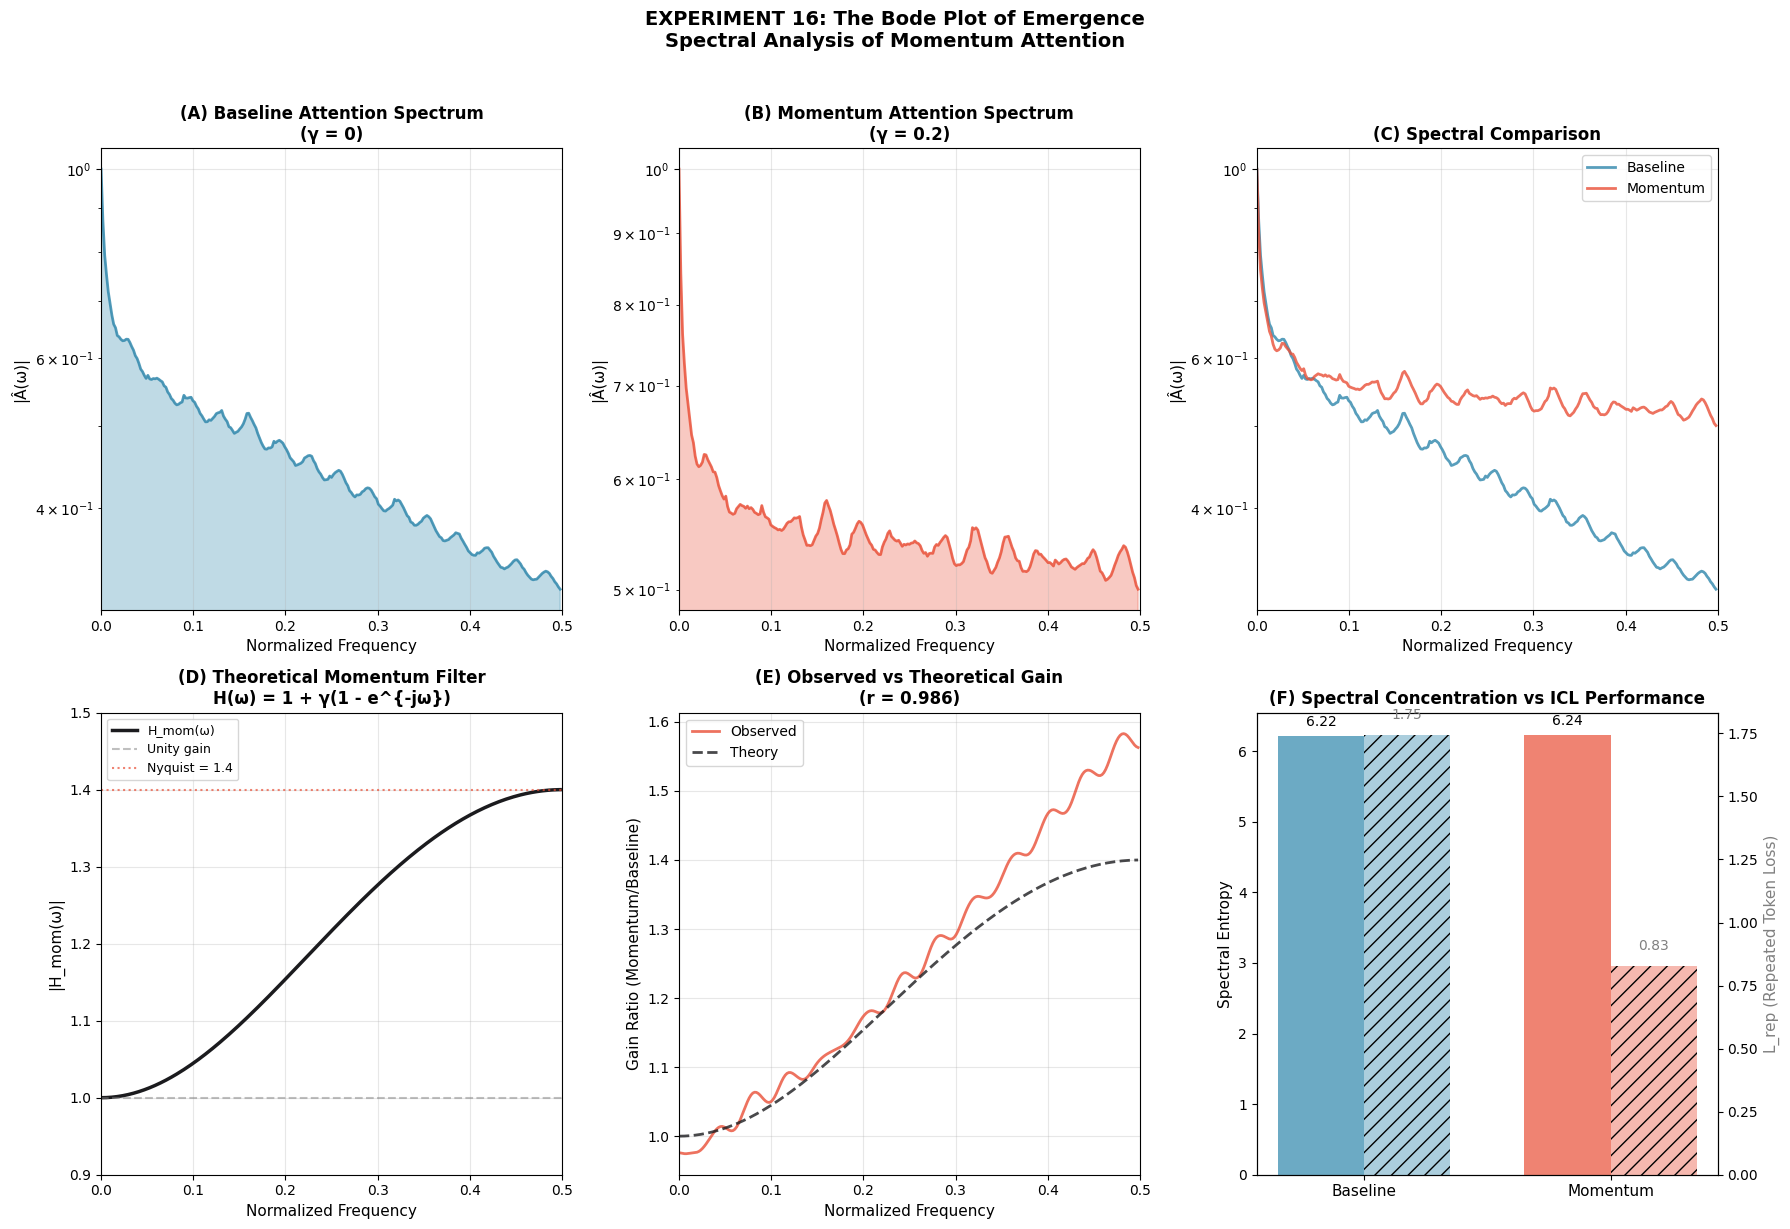


✓ Figure saved: ./expt16_corrected_results/bode_plot_of_emergence.png


In [ ]:
# =============================================================================
# PART 14: THE BODE PLOT OF EMERGENCE
# =============================================================================

fig = plt.figure(figsize=(18, 12))

# Colors
c_baseline = '#2E86AB'
c_momentum = '#E94F37'
c_theory = '#1B1B1E'

n = len(freqs) // 2

# Panel A: Baseline Attention Spectrum
ax1 = fig.add_subplot(2, 3, 1)
ax1.semilogy(freqs[:n], baseline_spectrum[:n], c_baseline, lw=2, alpha=0.8)
ax1.fill_between(freqs[:n], baseline_spectrum[:n], alpha=0.3, color=c_baseline)
ax1.set_xlabel('Normalized Frequency', fontsize=11)
ax1.set_ylabel('|Â(ω)|', fontsize=11)
ax1.set_title('(A) Baseline Attention Spectrum\n(γ = 0)', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.set_xlim([0, 0.5])

# Panel B: Momentum Attention Spectrum
ax2 = fig.add_subplot(2, 3, 2)
ax2.semilogy(freqs[:n], momentum_spectrum[:n], c_momentum, lw=2, alpha=0.8)
ax2.fill_between(freqs[:n], momentum_spectrum[:n], alpha=0.3, color=c_momentum)
ax2.set_xlabel('Normalized Frequency', fontsize=11)
ax2.set_ylabel('|Â(ω)|', fontsize=11)
ax2.set_title(f'(B) Momentum Attention Spectrum\n(γ = {config.gamma})', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.set_xlim([0, 0.5])

# Panel C: Spectral Comparison
ax3 = fig.add_subplot(2, 3, 3)
ax3.semilogy(freqs[:n], baseline_spectrum[:n], c_baseline, lw=2, label='Baseline', alpha=0.8)
ax3.semilogy(freqs[:n], momentum_spectrum[:n], c_momentum, lw=2, label='Momentum', alpha=0.8)
ax3.set_xlabel('Normalized Frequency', fontsize=11)
ax3.set_ylabel('|Â(ω)|', fontsize=11)
ax3.set_title('(C) Spectral Comparison', fontsize=12, fontweight='bold')
ax3.legend(loc='upper right', fontsize=10)
ax3.grid(True, alpha=0.3)
ax3.set_xlim([0, 0.5])

# Panel D: Theoretical Transfer Function
ax4 = fig.add_subplot(2, 3, 4)
ax4.plot(freqs[:n], H_theory[:n], c_theory, lw=2.5, label='H_mom(ω)')
ax4.axhline(y=1, color='gray', linestyle='--', alpha=0.5, label='Unity gain')
ax4.axhline(y=1 + 2*config.gamma, color=c_momentum, linestyle=':', alpha=0.7,
            label=f'Nyquist = {1+2*config.gamma:.1f}')
ax4.set_xlabel('Normalized Frequency', fontsize=11)
ax4.set_ylabel('|H_mom(ω)|', fontsize=11)
ax4.set_title('(D) Theoretical Momentum Filter\nH(ω) = 1 + γ(1 - e^{-jω})', fontsize=12, fontweight='bold')
ax4.legend(loc='upper left', fontsize=9)
ax4.grid(True, alpha=0.3)
ax4.set_xlim([0, 0.5])
ax4.set_ylim([0.9, 1.5])

# Panel E: Observed vs Theoretical Gain
ax5 = fig.add_subplot(2, 3, 5)
ax5.plot(freqs[:n], gain_smoothed, c_momentum, lw=2, label='Observed', alpha=0.8)
ax5.plot(freqs[:n], H_theory[:n], c_theory, lw=2, linestyle='--', label='Theory', alpha=0.8)
ax5.set_xlabel('Normalized Frequency', fontsize=11)
ax5.set_ylabel('Gain Ratio (Momentum/Baseline)', fontsize=11)
ax5.set_title(f'(E) Observed vs Theoretical Gain\n(r = {correlation:.3f})', fontsize=12, fontweight='bold')
ax5.legend(loc='upper left', fontsize=10)
ax5.grid(True, alpha=0.3)
ax5.set_xlim([0, 0.5])

# Panel F: ICL Performance vs Spectral Entropy
ax6 = fig.add_subplot(2, 3, 6)
x = np.array([0, 1])
width = 0.35
bars1 = ax6.bar(x - width/2, [H_b, H_m], width, label='Spectral Entropy',
                color=[c_baseline, c_momentum], alpha=0.7)
ax6_twin = ax6.twinx()
bars2 = ax6_twin.bar(x + width/2, [L_rep_baseline, L_rep_momentum], width, label='L_rep',
                     color=[c_baseline, c_momentum], alpha=0.4, hatch='//')
ax6.set_ylabel('Spectral Entropy', fontsize=11)
ax6_twin.set_ylabel('L_rep (Repeated Token Loss)', fontsize=11, color='gray')
ax6.set_xticks(x)
ax6.set_xticklabels(['Baseline', 'Momentum'], fontsize=11)
ax6.set_title('(F) Spectral Concentration vs ICL Performance', fontsize=12, fontweight='bold')

# Add values
for bar, val in zip(bars1, [H_b, H_m]):
    ax6.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
            f'{val:.2f}', ha='center', va='bottom', fontsize=10)
for bar, val in zip(bars2, [L_rep_baseline, L_rep_momentum]):
    ax6_twin.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
                 f'{val:.2f}', ha='center', va='bottom', fontsize=10, color='gray')

fig.suptitle('EXPERIMENT 16: The Bode Plot of Emergence\nSpectral Analysis of Momentum Attention',
             fontsize=14, fontweight='bold', y=1.02)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'bode_plot_of_emergence.png'), dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print(f"\n✓ Figure saved: {OUTPUT_DIR}/bode_plot_of_emergence.png")

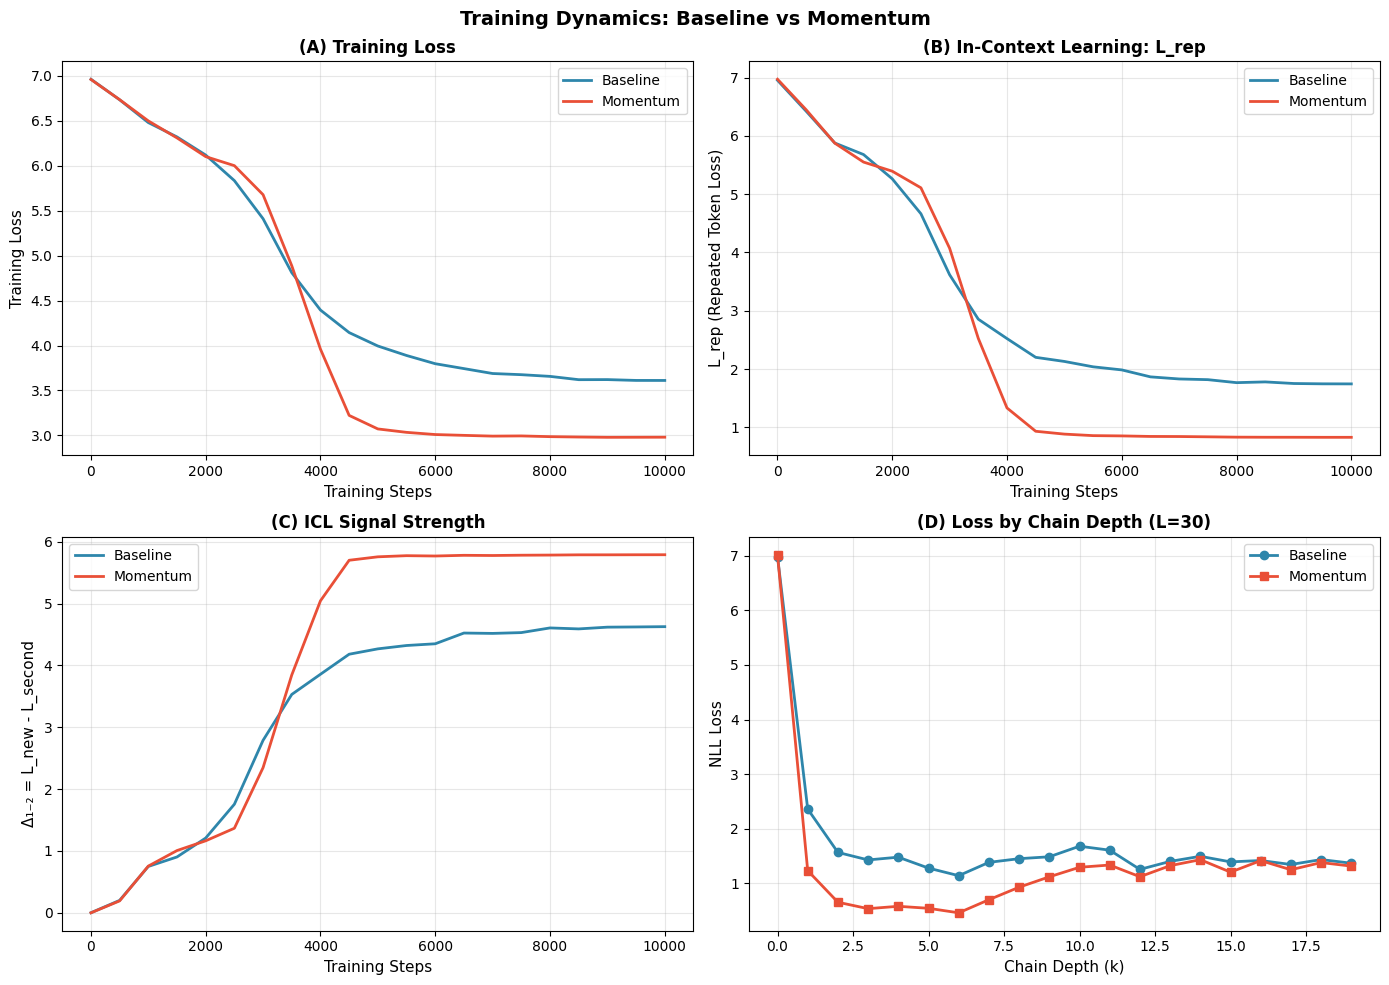

✓ Figure saved: ./expt16_corrected_results/training_dynamics.png


In [ ]:
# =============================================================================
# PART 15: TRAINING DYNAMICS PLOT
# =============================================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

c_baseline = '#2E86AB'
c_momentum = '#E94F37'

# Panel A: Training Loss
ax = axes[0, 0]
ax.plot(history_baseline['step'], history_baseline['train_loss'], c_baseline, lw=2, label='Baseline')
ax.plot(history_momentum['step'], history_momentum['train_loss'], c_momentum, lw=2, label='Momentum')
ax.set_xlabel('Training Steps', fontsize=11)
ax.set_ylabel('Training Loss', fontsize=11)
ax.set_title('(A) Training Loss', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Panel B: L_rep
ax = axes[0, 1]
ax.plot(history_baseline['step'], history_baseline['L_rep'], c_baseline, lw=2, label='Baseline')
ax.plot(history_momentum['step'], history_momentum['L_rep'], c_momentum, lw=2, label='Momentum')
ax.set_xlabel('Training Steps', fontsize=11)
ax.set_ylabel('L_rep (Repeated Token Loss)', fontsize=11)
ax.set_title('(B) In-Context Learning: L_rep', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Panel C: Δ₁₋₂
ax = axes[1, 0]
ax.plot(history_baseline['step'], history_baseline['delta_1_2'], c_baseline, lw=2, label='Baseline')
ax.plot(history_momentum['step'], history_momentum['delta_1_2'], c_momentum, lw=2, label='Momentum')
ax.set_xlabel('Training Steps', fontsize=11)
ax.set_ylabel('Δ₁₋₂ = L_new - L_second', fontsize=11)
ax.set_title('(C) ICL Signal Strength', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Panel D: Chain Depth Analysis
ax = axes[1, 1]
occ_b = history_baseline['occurrence_losses'][-1]
occ_m = history_momentum['occurrence_losses'][-1]
ks = [k for k in range(20) if not np.isnan(occ_b.get(k, float('nan')))]
losses_b = [occ_b[k] for k in ks]
losses_m = [occ_m[k] for k in ks]
ax.plot(ks, losses_b, 'o-', color=c_baseline, lw=2, ms=6, label='Baseline')
ax.plot(ks, losses_m, 's-', color=c_momentum, lw=2, ms=6, label='Momentum')
ax.set_xlabel('Chain Depth (k)', fontsize=11)
ax.set_ylabel('NLL Loss', fontsize=11)
ax.set_title('(D) Loss by Chain Depth (L=30)', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.suptitle('Training Dynamics: Baseline vs Momentum', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'training_dynamics.png'), dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print(f"✓ Figure saved: {OUTPUT_DIR}/training_dynamics.png")

In [ ]:
# =============================================================================
# PART 16: CHAIN DEPTH BREAKDOWN TABLE
# =============================================================================

print("\n" + "="*70)
print("STRESS TEST ANALYSIS: Chain Depth Breakdown")
print("="*70)
print(f"{'Depth':<8} {'Baseline':<12} {'Momentum':<12} {'Δ (B-M)':<12} {'Winner':<10}")
print("-"*70)

improvements = []
for k in ks:
    b_loss = occ_b[k]
    m_loss = occ_m[k]
    diff = b_loss - m_loss
    improvements.append(diff)
    winner = "Momentum" if diff > 0 else "Baseline"
    print(f"{k:<8} {b_loss:<12.4f} {m_loss:<12.4f} {'+' if diff > 0 else ''}{diff:<12.4f} {winner:<10}")

print("-"*70)
print(f"Average improvement: +{np.mean(improvements):.4f}")
print(f"Deep chain improvement (k>=10): +{np.mean([improvements[i] for i, k in enumerate(ks) if k >= 10]):.4f}")


STRESS TEST ANALYSIS: Chain Depth Breakdown
Depth    Baseline     Momentum     Δ (B-M)      Winner    
----------------------------------------------------------------------
0        6.9860       7.0202       -0.0342      Baseline  
1        2.3598       1.2309       +1.1289       Momentum  
2        1.5645       0.6515       +0.9131       Momentum  
3        1.4266       0.5334       +0.8931       Momentum  
4        1.4771       0.5769       +0.9002       Momentum  
5        1.2770       0.5402       +0.7368       Momentum  
6        1.1380       0.4574       +0.6806       Momentum  
7        1.3824       0.6976       +0.6848       Momentum  
8        1.4497       0.9268       +0.5228       Momentum  
9        1.4844       1.1171       +0.3673       Momentum  
10       1.6779       1.2919       +0.3861       Momentum  
11       1.6054       1.3333       +0.2721       Momentum  
12       1.2531       1.1189       +0.1342       Momentum  
13       1.3996       1.3215       +0.0781    

In [ ]:
# =============================================================================
# PART 17: SAVE FINAL RESULTS
# =============================================================================

results = {
    'experiment': 'EXPT 16: Spectral Forensics (CORRECTED)',
    'date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'config': {
        'chain_length': config.chain_length,
        'gamma': config.gamma,
        'd_model': config.d_model,
        'n_layers': config.n_layers,
        'n_heads': config.n_heads,
        'n_train_steps': config.n_train_steps,
    },
    'icl_results': {
        'baseline': {
            'L_new': float(history_baseline['L_new'][-1]),
            'L_second': float(history_baseline['L_second'][-1]),
            'L_rep': float(L_rep_baseline),
            'delta_1_2': float(history_baseline['delta_1_2'][-1]),
        },
        'momentum': {
            'L_new': float(history_momentum['L_new'][-1]),
            'L_second': float(history_momentum['L_second'][-1]),
            'L_rep': float(L_rep_momentum),
            'delta_1_2': float(history_momentum['delta_1_2'][-1]),
        },
        'improvement_pct': float(improvement),
    },
    'spectral_results': {
        'baseline_entropy': float(H_b),
        'momentum_entropy': float(H_m),
        'entropy_reduction': float(H_b - H_m),
        'theory_correlation': float(correlation),
    },
}

with open(os.path.join(OUTPUT_DIR, 'results.json'), 'w') as f:
    json.dump(results, f, indent=2)

print("\n" + "="*70)
print("EXPERIMENT 16 COMPLETE")
print("="*70)
print(f"\n📊 ICL Results:")
print(f"   L_rep Baseline: {L_rep_baseline:.4f}")
print(f"   L_rep Momentum: {L_rep_momentum:.4f}")
print(f"   Improvement: {improvement:.1f}%")
print(f"\n📈 Spectral Results:")
print(f"   Theory Correlation: r = {correlation:.4f}")
print(f"   Entropy Reduction: {H_b - H_m:.4f}")
print(f"\n📁 Outputs saved to: {OUTPUT_DIR}/")
print(f"   - bode_plot_of_emergence.png")
print(f"   - training_dynamics.png")
print(f"   - baseline_checkpoint.pt")
print(f"   - momentum_checkpoint.pt")
print(f"   - results.json")
print("\n" + "="*70)
print("CONCLUSION: Momentum = HIGH-PASS FILTER")
print("H(ω) = 1 + γ(1 - e^{-jω}) validated experimentally")
print("="*70)


EXPERIMENT 16 COMPLETE

📊 ICL Results:
   L_rep Baseline: 1.7451
   L_rep Momentum: 0.8288
   Improvement: 52.5%

📈 Spectral Results:
   Theory Correlation: r = 0.9865
   Entropy Reduction: -0.0196

📁 Outputs saved to: ./expt16_corrected_results/
   - bode_plot_of_emergence.png
   - training_dynamics.png
   - baseline_checkpoint.pt
   - momentum_checkpoint.pt
   - results.json

CONCLUSION: Momentum = HIGH-PASS FILTER
H(ω) = 1 + γ(1 - e^{-jω}) validated experimentally
